In [1]:
import sys, random
sys.path.insert(0, "/Users/Phu/DATA/projects/enact-generator")
import matplotlib.pyplot as plt
import haversine
from pygeodesy.sphericalNvector import LatLon
import pandas as pd
random.seed(0)

In [2]:
from enactclass import *

In [3]:
nm2m = 1852
m2nm = 0.000539957
ft2m = 0.3048
m2ft = 3.28084
REGION_LIMITS = [1., 100., 4., 104.]  # min_lat, min_lon, max_lat, max_lon
lat0, lon0 = 2.5, 102.5

In [4]:
# conflict inputs are in aviation units

def generate_aircraft_pair(lat0, lon0, counter_level, v_distance, h_distance, hdg0, counter_angle, ownship_cs, intruder_cs):
#     lat0 = 2.000  # lat of ownship at CPA
#     lon0 = 101.000  # lon of ownship at CPA
#     counter_level = 350  # hundred of ft
#     v_distance = 0 # ft
#     h_distance = 10 # nm
#     hdg0 = 90  # degree
#     counter_angle = 30  # degree
    ownship_phase = "CR"
    intruder_phase = "CR"
    ownship_type = "A320"
    intruder_type = "A320"
    look_ahead = 5  # minutes
#     ownship_cs  = "AUT001"
#     intruder_cs = "ATU002"
    bada_data_path = '/Users/Phu/DATA/projects/enact-generator/bada36_PTF.csv'

    conflict_params = ConflictInput(
        lat0, lon0, hdg0, \
        counter_level, counter_angle, h_distance, v_distance, \
        ownship_phase, intruder_phase, ownship_type, intruder_type, \
        ownship_cs, intruder_cs, look_ahead, bada_data_path
    )
    conflict = ConflictGenerator(conflict_params)
    conflict.compute_track(save_as='df')
    df = conflict.track
    ownship_track = df[df.CallSign==ownship_cs]
    intruder_track = df[df.CallSign==intruder_cs]
    return ownship_track, intruder_track


def los(track0, track1):
    location0 = [LatLon(lat, lon) for lat, lon in zip(track0.Latitude, track0.Longitude)]
    location1 = [LatLon(lat, lon) for lat, lon in zip(track1.Latitude, track1.Longitude)]
    h_distances = [p0.distanceTo(p1)*m2nm for p0, p1 in zip(location0, location1)]
    v_distances = [abs(h0-h1)*m2ft for h0, h1 in zip(track0.Height, track1.Height)]
    check = [ h_dist < 5. and v_dist < 1000. for h_dist, v_dist in zip(h_distances, v_distances)]
    return any(check)

def create_point(limits=REGION_LIMITS):
    lat = random.uniform(limits[0], limits[2])
    lon = random.uniform(limits[1], limits[3])
    return lat, lon

def randomize_aircraft_pair(fl, region_limits, v_distance=0, h_distance=15):
    lat0, lon0 = create_point(region_limits)
    hdg0 = random.randint(0,360)
    ownship_cs  = "AUT000"
    intruder_cs = "AUT001"
    track0, track1 = generate_aircraft_pair(lat0, lon0, counter_level, v_distance, h_distance, hdg0, counter_angle, ownship_cs, intruder_cs)
    return track0, track1 

def plot_tracks(tracks):
    for track in tracks:
        plt.plot(track.Longitude, track.Latitude)
        plt.axis('equal')

In [5]:
tracks = []  # tracks of all aircraft

# Generate conflict pair
counter_level = 350  # hundred of ft
v_distance = 0 # ft
h_distance = 4.1 # nm
hdg0 = 90  # degree
counter_angle = 30  # degree
ownship_cs  = "AUT000"
intruder_cs = "AUT001"
ownship, intruder = generate_aircraft_pair(lat0, lon0, counter_level, v_distance, h_distance, hdg0, counter_angle, ownship_cs, intruder_cs)
tracks += [ownship, intruder]

In [6]:
# Estimate the region limits

min_lat = min(min(tracks[0].Latitude), min(tracks[1].Latitude))
min_lon = min(min(tracks[0].Longitude), min(tracks[1].Longitude))
max_lat = max(max(tracks[0].Latitude), max(tracks[1].Latitude))
max_lon = max(max(tracks[0].Longitude), max(tracks[1].Longitude))
margin=0.25
region_limits = [min_lat-margin, min_lon-margin, max_lat+margin, max_lon+margin]

In [7]:
i = 0
while True:
    print(i, "Generated:", len(tracks))
    h_distance = random.uniform(10, 20)
    counter_level = random.choice([350, 310, 390])
    ac0, ac1 = randomize_aircraft_pair(counter_level, region_limits, v_distance=0, h_distance=h_distance)
    check0 = any([los(ac0, ac) for ac in tracks])
    check1 = any([los(ac1, ac) for ac in tracks])
    if (not check0) and (not check1):
        tracks += [ac0, ac1]
        if len(tracks) == 20:
            break
    i+=1

0 Generated: 2
1 Generated: 4
2 Generated: 6
3 Generated: 8
4 Generated: 10
5 Generated: 12
6 Generated: 14
7 Generated: 14
8 Generated: 16
9 Generated: 16
10 Generated: 18
11 Generated: 18
12 Generated: 18


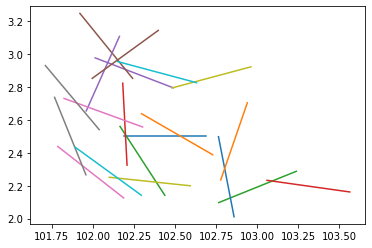

In [8]:
plot_tracks(tracks)

In [9]:
for i in range(len(tracks)):
    df = tracks[i]
    df.to_csv("data/tmp/ac_{}.csv".format(i), index=False)